### Imports

In [67]:
import os
import sys
import glob
import csv
import time
import platform
import socket
import random
import re
from datetime import datetime
from tqdm.auto import tqdm
from typing import Tuple, List, Callable

In [68]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import psutil  # For system resource monitoring
# import GPUtil  # For GPU information
import wandb

In [69]:
import torch
from torch import nn
import torch.optim as optim
from torchvision.io import decode_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

### Constants

In [70]:
from displacements import VectorFieldComposer, VECTOR_FIELDS

TILES_DIR = "../tiles"
# TILE_IMAGE_PATHS = glob.glob(os.path.join(TILES_DIR, "**/*.png"), recursive=True)
# TILE_IMAGE_PATHS = glob.glob(os.path.join(TILES_DIR, "g*/**/*.png"), recursive=True) # Just the graphite images
# print(TILE_IMAGE_PATHS)
# MAX_TILES = 50000
# NUM_TILES = min(MAX_TILES, len(TILE_IMAGE_PATHS))

TILE_SIZE = 256

sequence_arrays = {}

# Iterate through sequence folders (e.g., "78", "g60")
for sequence_name in os.listdir(TILES_DIR):
    sequence_path = os.path.join(TILES_DIR, sequence_name)

    if os.path.isdir(sequence_path):  # Ignore hidden files/folders
        tile_arrays = {}  # Dictionary for tile arrays within this sequence

        # Iterate through image folders within the sequence (e.g., "0001.tif", "0023.tif")
        for image_folder_name in os.listdir(sequence_path):
            image_folder_path = os.path.join(sequence_path, image_folder_name)

            if os.path.isdir(image_folder_path):
                # Iterate through the tile images within the image folder
                for tile_image_name in os.listdir(image_folder_path):
                    if tile_image_name.startswith("tile_") and tile_image_name.endswith(".png"):
                        try:
                            tile_number_match = re.search(r"tile_(\d+)\.png", tile_image_name)
                            if tile_number_match:
                                tile_number = int(tile_number_match.group(1))
                                tile_image_path = os.path.join(image_folder_path, tile_image_name)
                                if tile_number not in tile_arrays:
                                    tile_arrays[tile_number] = []
                                tile_arrays[tile_number].append(tile_image_path)

                        except ValueError:
                            print(f"Warning: Could not parse tile number from {tile_image_name} in {image_folder_path}")



        sequence_arrays[sequence_name] = tile_arrays  # Add the tile arrays for this sequence


# Model

In [71]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [72]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        # i learned about this in class today! the timing in on point!
        return self.conv(x) + self.residual(x)

class MotionVectorRegressionNetwork(nn.Module):
    def __init__(self, input_images = 2):
        super().__init__()
        # Outputs an xy motion vector per pixel
        self.input_images = input_images
        self.vector_channels = 2

        self.convolution = nn.Sequential(
            ConvolutionBlock(input_images, 32, kernel_size=3), # input_images (2) -> 32 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(32, 64, kernel_size=3), # 32 -> 64 channels
            nn.MaxPool2d(kernel_size=2), # scales down by half

            ConvolutionBlock(64, 128, kernel_size=3), # 64 -> 128 channels 
            ConvolutionBlock(128, 128, kernel_size=3), # 128 -> 128 channels
        ) 

        self.output = nn.Sequential(
            # scale back up
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 128 -> 64 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 64 -> 32 channels
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, self.vector_channels, kernel_size=3, stride=1, padding=1), # 32 -> 2 channels
        )

    def forward(self, x):
        # print(x.shape)
        x = self.convolution(x)
        # print(x.shape)
        x = self.output(x)
        # print(x.shape)
        return x

model = MotionVectorRegressionNetwork(input_images=2).to(device)
print(model)

MotionVectorRegressionNetwork(
  (convolution): Sequential(
    (0): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvolutionBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (residual): Sequential(
        (0):

# Testing

In [73]:
# testin gthe model

MODEL_FILE = "model2/tx7.pth"

model = MotionVectorRegressionNetwork().to(device)
model.load_state_dict(torch.load(MODEL_FILE, weights_only=True))

<All keys matched successfully>

0 255


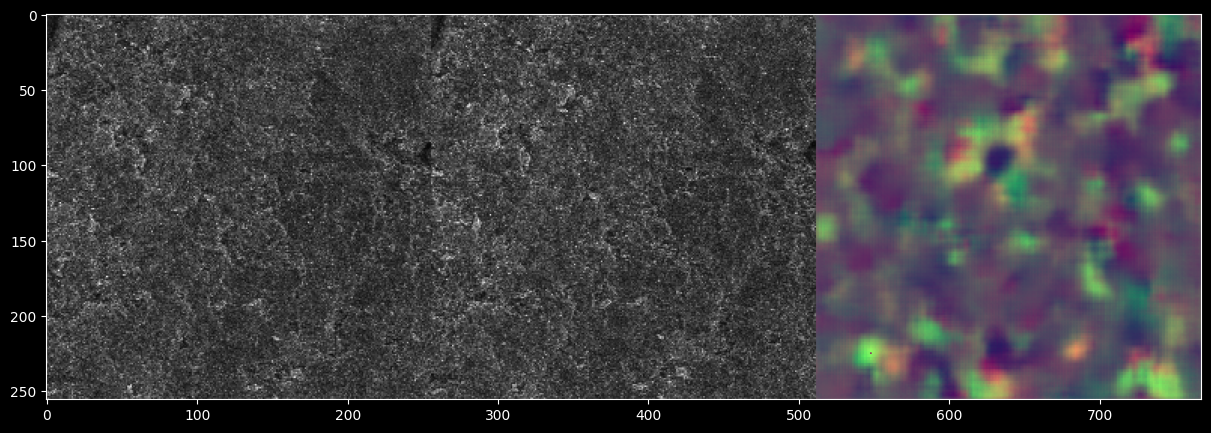

In [74]:
model.eval()

base_image_path = sequence_arrays['g60'][5][8]
next_time_path = sequence_arrays['g60'][5][9]

base_image = np.array(Image.open(base_image_path))
next_time = np.array(Image.open(next_time_path))

with torch.no_grad():
    X = torch.from_numpy(np.array([base_image, next_time])).float()
    X = X.unsqueeze(0)
    X = X.to(device)
    pred = model(X)
    
    converted_pred = pred[0].cpu().numpy()
    converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
    converted_pred = np.transpose(converted_pred, (1, 2, 0))
    converted_pred = (converted_pred - converted_pred.min()) / (converted_pred.max() - converted_pred.min())

    base_image = np.array((X[0, 0].cpu().numpy(),)*3)
    base_image = np.transpose(base_image, (1, 2, 0))
    next_time = np.array((X[0, 1].cpu().numpy(),)*3)
    next_time = np.transpose(next_time, (1, 2, 0))
    combined = np.hstack((base_image, next_time, converted_pred * 256)).astype(np.uint8)

    print(combined.min(),combined.max())

    plt.figure(figsize=(20, 5))
    plt.imshow(combined)
    plt.show()

Example 1:
  Image pair: ../tiles\g60\00001.tif\tile_5.png, ../tiles\g60\00002.tif\tile_5.png
  Combined image min/max: 0, 255


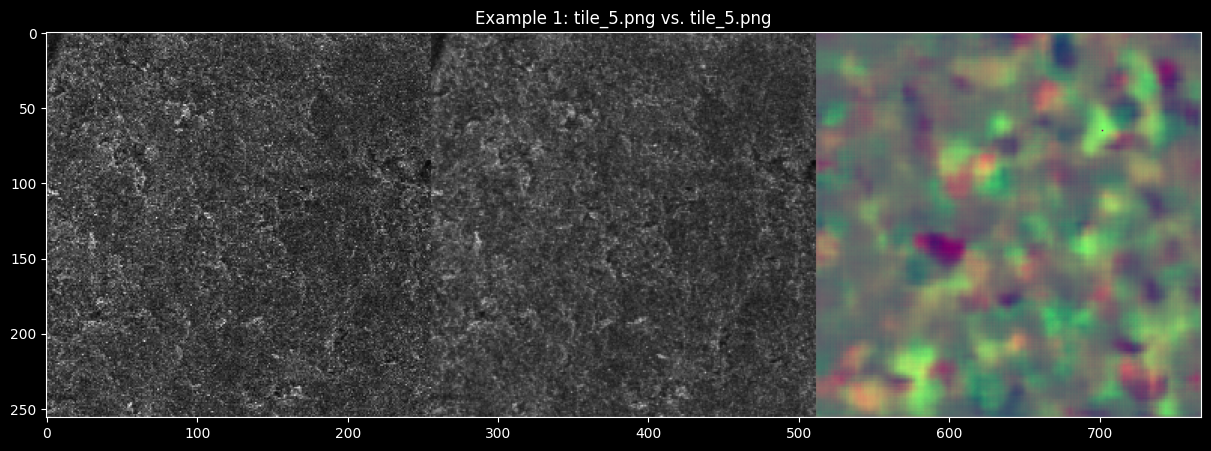

Example 2:
  Image pair: ../tiles\g60\00003.tif\tile_5.png, ../tiles\g60\00004.tif\tile_5.png
  Combined image min/max: 0, 255


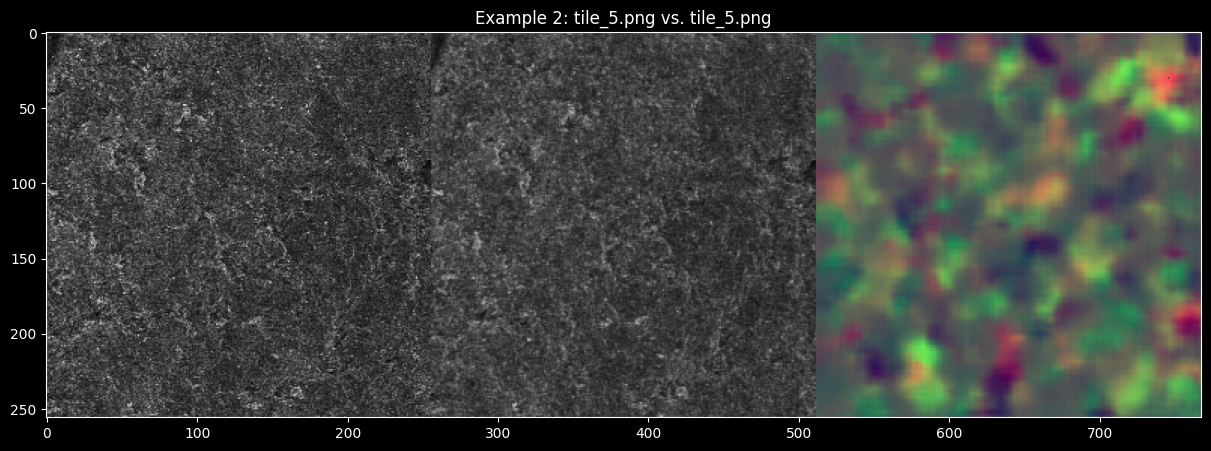

Example 3:
  Image pair: ../tiles\g60\00005.tif\tile_5.png, ../tiles\g60\00006.tif\tile_5.png
  Combined image min/max: 0, 255


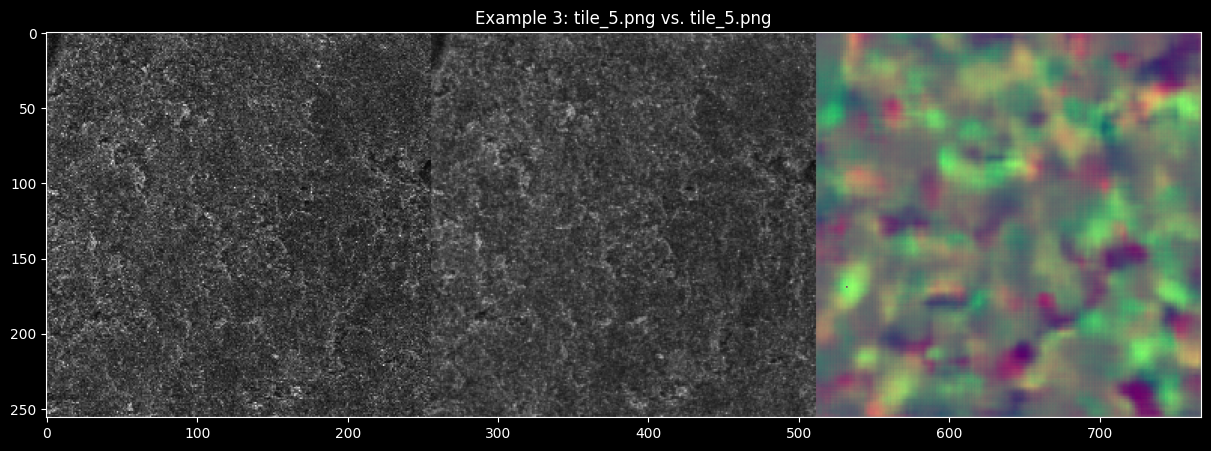

In [75]:
num_examples = 3  # Number of example pairs to process
sequence_name = 'g60' #choose a sequence
if sequence_name not in sequence_arrays:
    print(f"Sequence '{sequence_name}' not found in sequence_arrays. Please check your data.")
else:
    #get all the images for tile 5
    if 5 not in sequence_arrays[sequence_name]:
        print(f"Tile 5 not found in sequence '{sequence_name}'.")
    else:

        image_paths = sequence_arrays[sequence_name][5]
        if len(image_paths) < 10: #adjust to the number of images created in the above step
            print(f"Sequence '{sequence_name}' does not have at least 10 images for tile 5.  Adjust the loop or create more image folders.")
        else:


            for example_index in range(num_examples):
                try:
                    base_image_path = image_paths[example_index * 2] #0, 2, 4
                    next_time_path = image_paths[example_index * 2 + 1] #1, 3, 5

                   # Load and blur the next image
                    base_image = np.array(Image.open(base_image_path))
                    next_time_pil = Image.open(next_time_path)
                    next_time_pil = next_time_pil.filter(ImageFilter.GaussianBlur(radius=0.5)) #radius controls the amount of blur
                    next_time = np.array(next_time_pil) # Convert back to numpy array

                    with torch.no_grad():
                        X = torch.from_numpy(np.array([base_image, next_time])).float()
                        X = X.unsqueeze(0)
                        X = X.to(device)
                        pred = model(X)

                        converted_pred = pred[0].cpu().numpy()
                        converted_pred = np.vstack((converted_pred, np.zeros((1, converted_pred.shape[1], converted_pred.shape[2]))))
                        converted_pred = np.transpose(converted_pred, (1, 2, 0))
                        converted_pred = (converted_pred - converted_pred.min()) / (converted_pred.max() - converted_pred.min())

                        base_image = np.array((X[0, 0].cpu().numpy(),)*3)
                        base_image = np.transpose(base_image, (1, 2, 0))
                        next_time = np.array((X[0, 1].cpu().numpy(),)*3)
                        next_time = np.transpose(next_time, (1, 2, 0))
                        combined = np.hstack((base_image, next_time, converted_pred * 256)).astype(np.uint8)

                        combined = np.hstack((base_image, morph_image, converted_y * 256, converted_pred * 256)).astype(np.uint8)

                        print(combined.min(),combined.max())

                        plt.figure(figsize=(20, 5))
                        plt.imshow(combined)
                        plt.show()

                        print(f"Example {example_index + 1}:")
                        print(f"  Image pair: {base_image_path}, {next_time_path}")
                        print(f"  Combined image min/max: {combined.min()}, {combined.max()}")

                        plt.figure(figsize=(20, 5))
                        plt.imshow(combined)
                        plt.title(f"Example {example_index + 1}: {os.path.basename(base_image_path)} vs. {os.path.basename(next_time_path)}") #more descriptive
                        plt.show()

                except IndexError:
                    print(f"Not enough image pairs for example {example_index + 1}.  Reduce num_examples or generate more image folders")
                    break  # Stop if there are not enough pairs
                except FileNotFoundError as e:
                    print(f"File not found: {e}.  Check paths.")
                    break
                except Exception as e: #catch other exceptions and print
                    print(f"An error occurred during processing example {example_index + 1}: {e}")
                    break